In [198]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [199]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [200]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [201]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

Загрузка датасета

In [215]:
# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/content/boston.csv")

# Display the first 3 examples.
dataset_df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


Функция для разделения датасета на выборку для обучения и выборку для тестирования (в соотношении 70 к 30)

In [203]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

364 examples in training, 142 examples for testing.


Поместить в лэйбл имя предсказываемого параметра

In [204]:
# Name of the label column.
label = "MEDV"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

Обучение модели на регрессию

In [ ]:
%set_cell_height 300

# Configure the model.
model_RF = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION,  num_trees=1000)

# Train the model.
history = model_RF.fit(x=train_ds)

Сохранение модели

In [206]:
model_RF.save("/tmp/my_saved_model")

Оценка модели по MSE, RMSE, MAE и MAPE

In [207]:
# Evaluate the model on the test dataset.
model_RF.compile(metrics=["mse", "mae", "mape"])
evaluation = model_RF.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print(f"MAE: {evaluation['mae']}")
print(f"MAPE: {evaluation['mape']}")
tfdf.model_plotter.plot_model_in_colab(model_RF, tree_idx=400, max_depth=4)

#model_RF.make_inspector().variable_importances()

1/1 [==============================] - 0s 320ms/step - loss: 0.0000e+00 - mse: 14.4374 - mae: 2.3988 - mape: 11.7897
{'loss': 0.0, 'mse': 14.437424659729004, 'mae': 2.398761510848999, 'mape': 11.789653778076172}

MSE: 14.437424659729004
RMSE: 3.799661124327932
MAE: 2.398761510848999
MAPE: 11.789653778076172


Вывод различной информации о модели

In [ ]:
%set_cell_height 300
model_RF.summary()

In [ ]:
model_RF.make_inspector().features()
%set_cell_height 150
model_RF.make_inspector().training_logs()

Визуализация снижения ошибки RMSE

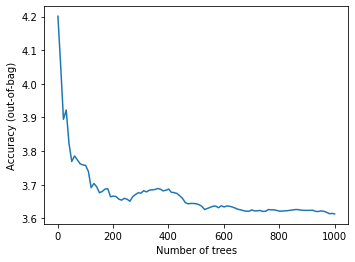

In [221]:
import matplotlib.pyplot as plt

logs = model_RF.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()